# L5: Self-Reflecting Agents with Loops


In this notebook, we will create a self-reflecting pipeline that functions as a self-reflecting agent.

But what exactly is self-reflection?

**Self-reflection** is the process of performing a self-assessment, where an entity iteratively reviews and refines its responses to provide more reliable and accurate information.

By incorporating self-reflection, we enable our pipeline to generate feedback and refine its output accordingly. We can also define a specific status or criterion, allowing the LLM to continue iterating on its response until it meets the desired standard. With the appropriate commands, it is even possible to identify what went wrong and how to improve in subsequent iterations

How will we make our self-reflecting pipeline for this example? 

We will follow these steps:

1. First, we will feed a specific text as a query into our prompt builder.

2. The generator (our LLM) will take this prompt and execute it, attempting to extract certain variables or entities from the text.

3. If the generator successfully extracts the entities, it will produce an output. If the entities are unclear, the generator will loop the input back to the prompt builder for refinement.

This loop will continue until the generator determines that the entities are clear. To prevent an infinite loop, we can also set a limit on the number of iterations the generator is allowed to perform.

In [1]:
import sys

sys.path.append("..")

In [13]:
import warnings
import helper
import haystack_lib

warnings.filterwarnings('ignore')
helper.load_env()

In [3]:
%pip list | grep haystack

cohere-haystack           4.2.1
haystack-ai               2.14.2
haystack-experimental     0.10.0
Note: you may need to restart the kernel to use updated packages.


Note: If you need any library like colorama, just run %pip install colorama in a python line

In [5]:
from typing import List
from colorama import Fore
from haystack import Pipeline, component
from haystack.components.builders.prompt_builder import PromptBuilder

### Create an EntitiesValidator


We will start by creating a new custom component called `EntitiesValidator`, which will take the output from the generator and show, if the LLM is not sure yet, what entities is the generator reflecting on.

On the other hand, if the LLM update its response to DONE, it will display these entities in its final form :



In [6]:
@component
class EntitiesValidator:

    @component.output_types(entities_to_validate=str, entities=str)
    def run(self, replies: List[str]):
        if 'DONE' in replies[0]:
            return {"entities":replies[0].replace('DONE', '')}
        else:
            print(Fore.RED + "Reflecting on entities\n", replies[0])
            return {"entities_to_validate": replies[0]}

Let's make a quick test

In [7]:
entities_validator = EntitiesValidator()
entities_validator.run(replies= ["{'name': 'David'}"])

Reflecting on entities
 {'name': 'David'}


{'entities_to_validate': "{'name': 'David'}"}

In [8]:
entities_validator.run(replies= ["DONE {'name': 'David'}"])

{'entities': " {'name': 'David'}"}

### Create a conditional template for our prompt builder


In this template, we specify exaclty what type of entities we want to extract from a input text.
This is a very simple template, which doesn't really allow any iteration for our LLM.

In [9]:
template = """

Extract entities from the following text
Text : {{ text }}
The entities should be presented as key-value pairs in a JSON object.
Example:
{
    "Person": ["value1", "value2"],
    "Location": ["value3", "value4"],
    "Date": ["value5", "value6"]
}
If there are no possibilities for a particular category, run an empty list
for the category
Entities:

"""

Now, we aim to improve this tempalte with some changes.

First, we add an if statement so we review if we have entities to validate. We then give some bulletpoints on which things need to be double checked and could be improved. We also add a statement for the llm to say 'DONE' if it think it is done to implement self-reflection.

If we don't have entities to validate ( if they have been validated already), we go through the same part of the template we created before.

In [10]:
template = """"
{% if entities_to_validate %}
    Here was the text you were provided:
    {{ text }}
    Here are the entities you previously extracted: 
    {{ entities_to_validate[0] }}
    Are these the correct entities? 
    Things to check for:
    - Entity categories should exactly be "Person", "Location" and "Date"
    - There should be no extra categories
    - There should be no duplicate entities
    - If there are no appropriate entities for a category, the category should have an empty list
    If you are done say 'DONE' and return your new entities in the next line
    If not, simply return the best entities you can come up with.
    Entities:
{% else %}
    Extract entities from the following text
    Text: {{ text }} 
    The entities should be presented as key-value pairs in a JSON object.
    Example: 
    {
        "Person": ["value1", "value2"], 
        "Location": ["value3", "value4"],
        "Date": ["value5", "value6"]
    }
    If there are no possibilities for a particular category, return an empty list for this
    category
    Entities:
{% endif %}
"""

### Create A Self-Reflecting Agent

Let's start creating our self reflecting agent.

First, we have our [`promptbuilder`](https://docs.haystack.deepset.ai/reference/experimental-builders-api#module-haystack_experimentalcomponentsbuilderschat_prompt_builder) with the template we created in the previous steps.
We have then our llm which can be any, on this example we work with OpenAI generator with the default model ( gpt-3).

We then add the `EntitiesValidator component we just created. We have a pipeline with a maximum number of loops so we don't do more requests than we want from our model providor ( OpenAI in this example). This means that if our self-reflection model doesn't generate a correct content for 10 loops, our pipeline will fail.

In [11]:
api_url = helper.get_env_var("API_BASE_URL")
model_phi = helper.get_env_var("MODEL_PHI")

This time, we will use MiniPHIChat, our custom component that uses phi-3-mini-4k chat version component.

In [ ]:
llm_chat =  haystack_lib.MiniPHIChat

Let's create now the pipeline 

In [15]:
prompt_template = PromptBuilder(template=template)
llm = haystack_lib.MiniPHILLM()
entities_validator = EntitiesValidator()
self_reflecting_agent = Pipeline(max_runs_per_component=2)

self_reflecting_agent.add_component("prompt_builder", prompt_template)
self_reflecting_agent.add_component("entities_validator", entities_validator)
self_reflecting_agent.add_component("llm", llm)

# Connect
self_reflecting_agent.connect("prompt_builder.prompt", "llm.prompt")
self_reflecting_agent.connect("llm.replies", "entities_validator.replies")
self_reflecting_agent.connect("entities_validator.entities_to_validate", "prompt_builder.entities_to_validate")

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


🚅 Components
  - prompt_builder: PromptBuilder
  - entities_validator: EntitiesValidator
  - llm: MiniPHILLM
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - entities_validator.entities_to_validate -> prompt_builder.entities_to_validate (str)
  - llm.replies -> entities_validator.replies (List[str])

As shown in the diagram, our entities validator enables a closed-loop system in which the prompt builder can continuously receive entities for validation and pass them back to the generator. This setup facilitates iterative refinement of the entities.

In this example, we are specifying `max_runs_per_component=2` for the first time. This setting prevents the pipeline from entering an infinite loop by limiting the number of execution cycles per component. However, it's important to note that once this limit is reached, the pipeline will raise an error. Therefore, relying solely on max_runs_per_component for control flow isn't ideal. An alternative approach would be to run the pipeline within a try block and handle potential exceptions explicitly, and we will do so soon.

There are better alternatives, and we will show one of them after showcasing a try block.

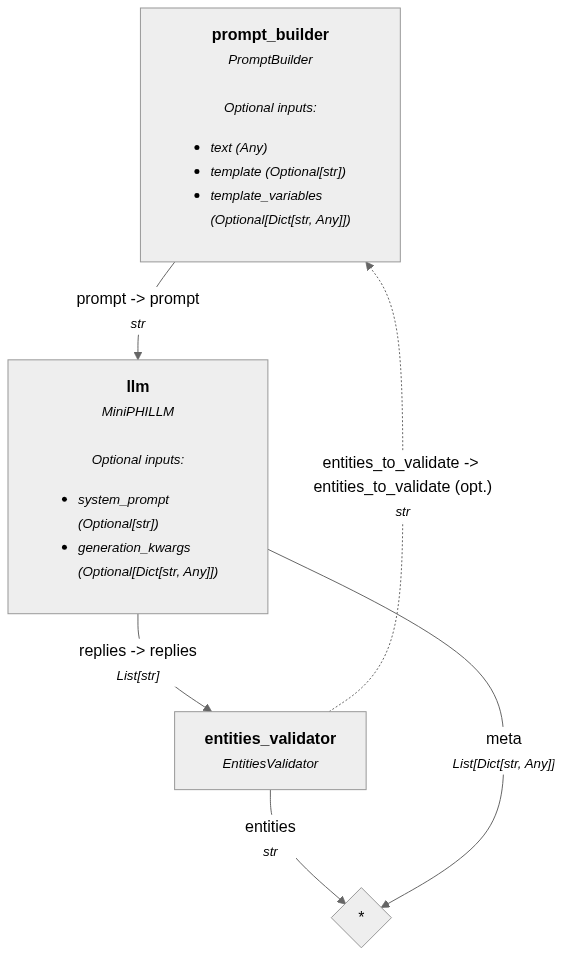

In [16]:
self_reflecting_agent.show()

In this text, there are some places mentioned we would like to catch in our entities validator. We are looking only for **location**, **date** and **person**. Our pipeline should only return the cities and continents mentioned in this text and ignore other type of information, maybe adding "residents" would be valid as person depending the perspective, but that's it.

Let's see how it performs and see what is the iterative process:

In [17]:
text = """
Istanbul is the largest city in Turkey, straddling the Bosporus Strait, 
the boundary between Europe and Asia. It is considered the country's economic, 
cultural and historic capital. The city has a population of over 15 million residents, 
comprising 19% of the population of Turkey,[4] and is the most populous city in Europe 
and the world's fifteenth-largest city."""

result = self_reflecting_agent.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result['entities_validator']['entities'])

Reflecting on entities
  {
    "City": ["Istanbul"],
    "Country": ["Turkey"],
    "Geographical Feature": ["Bosporus Strait"],
    "Continents": ["Europe", "Asia"],
    "Economic, Cultural and Historic Capital": ["Istanbul"],
    "Population Statistics": {
        "Residents Population": ["over 15 million residents"],
        "Percentage of Turkey's Population": ["19%"],
        "Largest City in Europe": ["Istanbul"],
        "World Ranking by Population": ["fifteenth-largest city"]
    }
}
 

New entities:

Location: Istanbul, Turkey; Bosporus Strait; Europe; Asia

Population data (Date): Over 15 million residents (as of current time), 19% of the population of Turkey

Note: The given text does not contain explicit person names or specific historical dates that would fit into "Person" and "Date" categories separately. Therefore, I've provided location-related data and a general reference to population percentage which can be considered as temporal information related to the current d

Let's try to modify our template so we get only json results


In [18]:
template_json = """"
{% if entities_to_validate %}
    Here was the text you were provided:
    {{ text }}
    Here are the entities you previously extracted: 
    {{ entities_to_validate }}
    Are these the correct entities? 
    Things to check for:
    - The only valid entity categories are: "Person", "Location", and "Date".
    - Each entity value must be less than 6 words.
    - There must be no duplicate entities.
    - If a category has no entities, return it as an empty list.

    Do NOT include any other categories like "Population", "Organization", or "Country".
    Your final JSON must include ONLY: "Person", "Location", and "Date".

    If you're done:
    - Write ONLY the word DONE on the first line.
    - On the next line, return the final JSON like this:
    {
        "Person": [],
        "Location": ["value1", "value2"],
        "Date": []
    }
    If you are not done, simply return the best entities you can come up with.

Entities:
{% else %}
    Extract entities from the following text
    Text: {{ text }} 
    The entities should be presented as key-value pairs in a JSON object.
    Example: 
    {
        "Person": ["value1", "value2"], 
        "Location": ["value3", "value4"],
        "Date": ["value5", "value6"]
    }
    The only entities shown must be Person, Location and Date as in the example.
    If there are no possibilities for a particular category, return an empty list for this category.
    Entities:
{% endif %}
"""

In [19]:
prompt_template = PromptBuilder(template=template_json)
llm = haystack_lib.MiniPHILLM()
entities_validator = EntitiesValidator()
self_reflecting_agent = Pipeline(max_runs_per_component=10)

self_reflecting_agent.add_component("prompt_builder", prompt_template)
self_reflecting_agent.add_component("entities_validator", entities_validator)
self_reflecting_agent.add_component("llm", llm)

# Connect
self_reflecting_agent.connect("prompt_builder.prompt", "llm.prompt")
self_reflecting_agent.connect("llm.replies", "entities_validator.replies")
self_reflecting_agent.connect("entities_validator.entities_to_validate", "prompt_builder.entities_to_validate")

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


🚅 Components
  - prompt_builder: PromptBuilder
  - entities_validator: EntitiesValidator
  - llm: MiniPHILLM
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - entities_validator.entities_to_validate -> prompt_builder.entities_to_validate (str)
  - llm.replies -> entities_validator.replies (List[str])

Witht his version, we will reach an error for a maximum time running the components, so we run it with this expection to show how would be the the last result we got: 

In [20]:
result = self_reflecting_agent.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result['entities_validator']['entities'])

Reflecting on entities
  ```json
{
    "Location": ["Istanbul", "Turkey", "Bosporus Strait", "Europe", "Asia"],
    "Population": ["15 million residents", "19% of the population of Turkey"]
}
```
Note: The given instructions do not explicitly ask for extracting entities related to Person or Date. However, since locations and demographic information are requested as per example format, I've omitted Person and Date from this response but included Population which is a key-value pair derived directly from the provided text. If needed, one could argue that "Turkey" might relate to Country (not explicitly listed in the categories) or potentially be considered under Location depending on interpretation scope.
 

{
    "Person": [],
    "Location": ["Istanbul", "Bosporus Strait", "Europe", "Asia", "Turkey"],
    "Date": []
}

Note: I've removed the population information as it doesn't fit within the specified entity categories (Person, Location, and Date). The 'Country' category has been impl

This is a big improvement in the way we obtain our entities, and redacting the right prompt is utterly important to obtain the desired results. Let's try to see what would happen if our pipeline reach the number of maximum run counts:

In [21]:
template_error = """"
{% if entities_to_validate %}
    Here was the text you were provided:
    {{ text }}
    Here are the entities you previously extracted: 
    {{ entities_to_validate }}
    Are these the correct entities? 
    Things to check for:
    - The only valid entity categories are: "Person", "Location", and "Date".
    - Each entity value must be less than 6 words.
    - There must be no duplicate entities.
    - If a category has no entities, return it as an empty list.
    - Your final JSON MUST include ONLY: "Person", "Location", and "Date".
    - All these entities must appear. If there is no value, show empty list for it.

    You are allowed to have other categories while refining these previous categories that MUST be in the final message.


Entities:
{% else %}
    Extract entities from the following text
    Text: {{ text }} 
    The entities should be presented as key-value pairs in a JSON object.
    Example: 
    {
        "Person": ["value1", "value2"], 
        "Location": ["value3", "value4"],
        "Date": ["value5", "value6"]
    }
    The only entities shown must be Person, Location and Date as in the example.
    If there are no possibilities for a particular category, return an empty list for this category.
    Entities:
{% endif %}
"""

In [22]:
prompt_template = PromptBuilder(template=template_error)
llm = haystack_lib.MiniPHILLM()
entities_validator = EntitiesValidator()
self_reflecting_agent = Pipeline(max_runs_per_component=2)

self_reflecting_agent.add_component("prompt_builder", prompt_template)
self_reflecting_agent.add_component("entities_validator", entities_validator)
self_reflecting_agent.add_component("llm", llm)

# Connect
self_reflecting_agent.connect("prompt_builder.prompt", "llm.prompt")
self_reflecting_agent.connect("llm.replies", "entities_validator.replies")
self_reflecting_agent.connect("entities_validator.entities_to_validate", "prompt_builder.entities_to_validate")

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


🚅 Components
  - prompt_builder: PromptBuilder
  - entities_validator: EntitiesValidator
  - llm: MiniPHILLM
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - entities_validator.entities_to_validate -> prompt_builder.entities_to_validate (str)
  - llm.replies -> entities_validator.replies (List[str])

In [23]:
try:
    result = self_reflecting_agent.run({"prompt_builder": {"text": text}})
    print(Fore.GREEN + result['entities_validator']['entities'])
except Exception as e:
    print("⚠️ Max iterations reached or another error occurred. Partial result:")
    print(Fore.YELLOW + result['entities_validator']['entities'])
    print(f"Error: {e}")


Reflecting on entities
  ```json
{
    "Location": ["Istanbul", "Turkey", "Bosporus Strait", "Europe", "Asia"]
}
```
Reflecting on entities
  ```json
{
    "Person": [],
    "Location": ["Istanbul", "Turkey", "Bosporus Strait", "Europe", "Asia"],
    "Date": []
}
```

Given the requirements, I've refined the entity categories to include only "Person," "Location," and "Date." Since there were no dates mentioned in the text provided, an empty list for "Date" is returned. There are no persons or specific dates, so their lists remain empty. Additionally, all entities from the original list have been confirmed to be valid Location entries as per the rules specified.
Reflecting on entities
  ```json
{
    "Person": [],
    "Location": ["Istanbul", "Turkey", "Bosporus Strait", "Europe", "Asia"],
    "Date": []
}
```
⚠️ Max iterations reached or another error occurred. Partial result:
 

{
    "Person": [],
    "Location": ["Istanbul", "Bosporus Strait", "Europe", "Asia", "Turkey"],
    "Date"

The original tutorial done on a version bellow Haystack 2.x, allows a maxiumum amount of runs per component. If we have a pipeline that runs on a loop like the one we did above, we have the option of running our pipeline expecting an expection from which we would get a response after a maximum number of runs.

Another way we could work around this is making an internal counter and obtaining the last answer.

In [16]:
from typing import Optional
from haystack import component

@component
class ControlledCounter:
    def __init__(self, max_iterations: int = 3):
        self.max_iterations = max_iterations
        self.iteration = 0

    @component.output_types(iteration=int, entities_to_validate=str, entities=str)
    def run(self, replies: List[str]):
        self.iteration = self.iteration + 1
        print(f"⬆️ Counter incremented value to: {self.iteration}")

        # If max iterations reached, override entities_to_validate with "DONE"
        if self.iteration >= self.max_iterations:
            print(f" Max iterations {self.max_iterations} reached. Entities should show DONE signal.")
            return {"iteration": self.iteration, "entities_to_validate": replies[0]}
        else:
            # Pass entities along normally
            print(f"↩️ Passing entities_to_validate through: { replies[0]}")
            return {"iteration": self.iteration, "entities_to_validate": replies[0]}

In [17]:

@component
class EntitiesValidatorCount:
    def __init__(self, max_iterations: int = 3):
        self.max_iterations = max_iterations
    @component.output_types(entities_to_validate=str, entities=str)
    def run(self, replies: List[str],iteration: Optional[int] = 0):

        # ✅ Force DONE after max_iterations
        if iteration >= self.max_iterations:
            print(Fore.YELLOW + f" Max iterations ({self.max_iterations}) reached. Forcing DONE.")
            return {"entities": replies[0].replace('DONE', '')}
        
        if 'DONE' in replies[0]:
            return {"entities":replies[0].replace('DONE', '')}
        else:
            print(Fore.RED + "Reflecting on entities\n", replies[0])
            return {"entities_to_validate": replies[0]}

We create a new self reflecting pipeline with the new counter component and the new entities validator that reads counts.

In [18]:
prompt_template = PromptBuilder(template=template)
llm = haystack_lib.MiniPHILLM()
entities_validator = EntitiesValidatorCount()
control_counter = ControlledCounter(4)
self_reflecting_agent_counter = Pipeline(max_runs_per_component=3)

In [101]:
self_reflecting_agent_counter.add_component("prompt_builder", prompt_template)
self_reflecting_agent_counter.add_component("entities_validator", entities_validator)
self_reflecting_agent_counter.add_component("llm", llm)
self_reflecting_agent_counter.add_component("counter", control_counter)

In [102]:
# Connect
self_reflecting_agent_counter.connect("prompt_builder.prompt", "llm.prompt")
self_reflecting_agent_counter.connect("llm.replies", "entities_validator.replies")
self_reflecting_agent_counter.connect("llm.replies", "counter.replies")
self_reflecting_agent_counter.connect("counter.iteration", "entities_validator.iteration")
self_reflecting_agent_counter.connect("entities_validator.entities_to_validate", "prompt_builder.entities_to_validate")

🚅 Components
  - prompt_builder: PromptBuilder
  - entities_validator: EntitiesValidatorCount
  - llm: MiniPHILLM
  - counter: ControlledCounter
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - entities_validator.entities_to_validate -> prompt_builder.entities_to_validate (str)
  - llm.replies -> entities_validator.replies (List[str])
  - llm.replies -> counter.replies (List[str])
  - counter.iteration -> entities_validator.iteration (int)

This is how the structure looks like. Notice that for a component to work, it will be on a state that will wait for all the inputs to come. Our llm will send its outputs to the entities validator and the counter, but entities validator will only work once counter sends it iteration output to the entities validator.

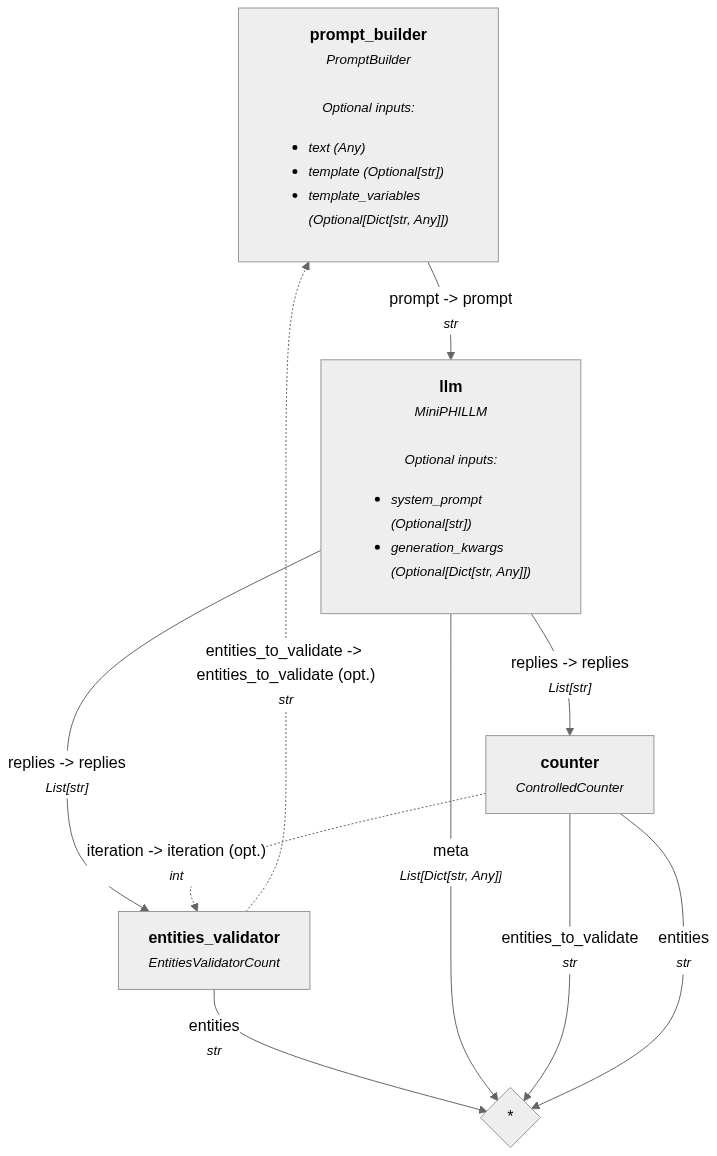

In [103]:
self_reflecting_agent_counter.show()

Let's try to run it again on this new pipeline ! 

In [104]:
result_counter = self_reflecting_agent_counter.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result_counter['entities_validator']['entities'])

⬆️ Counter incremented value to: 1
↩️ Passing entities_to_validate through:  {
    "City": ["Istanbul"],
    "Country": ["Turkey"],
    "GeographicalFeature": ["Bosporus Strait", "Europe-Asia boundary"],
    "CapitalStatus": ["economic capital", "cultural and historic capital"],
    "Population": ["over 15 million residents", "19% of Turkey's population"],
    "LocationRankingInEurope": ["most populous city in Europe"],
    "GlobalCityRanking": ["world's fifteenth-largest city"]
}
Reflecting on entities
  {
    "City": ["Istanbul"],
    "Country": ["Turkey"],
    "GeographicalFeature": ["Bosporus Strait", "Europe-Asia boundary"],
    "CapitalStatus": ["economic capital", "cultural and historic capital"],
    "Population": ["over 15 million residents", "19% of Turkey's population"],
    "LocationRankingInEurope": ["most populous city in Europe"],
    "GlobalCityRanking": ["world's fifteenth-largest city"]
}
⬆️ Counter incremented value to: 2
↩️ Passing entities_to_validate through:  DON

Let's have a closer comparison

In [90]:
print(Fore.GREEN + result_counter['entities_validator']['entities'])

 ```json
{
    "City": ["Istanbul"],
    "Country": ["Turkey"],
    "GeographicalFeature": ["Bosporus Strait", "Europe", "Asia"],
    "EconomicRole": ["economic", "capital"],
    "Population": ["over 15 million residents", "19% of the population of Turkey"],
    "CityRanking": ["most populous city in Europe", "fifteenth-largest city"]
}
```


In [91]:
print(Fore.GREEN + result['entities_validator']['entities'])

 

New entities:

Location: ["Istanbul", "Bosporus Strait", "Europe", "Asia", "Turkey"]


We can see the pipeline did as we wished : The first iteration we had only a Location entity obtained from the text. The final results contains now the entities Person and Date with an empty list as the pipeline didn't find related information.

In [11]:
text = """
Stefano: Hey all, let's start the all hands for June 6th 2024
Geoff: Thanks, I'll kick it off with a request. Could we please add persistent memory to the Chroma document store.
Stefano: Easy enough, I can add that to the feature requests. What else?
Julain: There's a bug, some BM25 algorithms return negative scores and we filter them out from the results by default.
Instead, we should probably check which algorithm is being used and keep results with negative scores accordingly.
Esmail: Before we end this call, we should add a new Generator component for LlamaCpp in the next release.
Tuana: Thanks all, I think we're done here, we can create some issues in GitHub about these."""

result = self_reflecting_agent.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result['entities_validator']['entities'])

Reflecting on entities
 {
    "Person": ["Stefano", "Geoff", "Julain", "Esmail", "Tuana"],
    "Date": ["June 6th 2024"]
}
{
    "Person": [
        "Stefano",
        "Geoff",
        "Julian",
        "Esmail",
        "Tuana"
    ],
    "Location": [],
    "Date": [
        "June 6th 2024"
    ]
}



We got here a similar result now. We had in our first iteration Person and Date entities and obtained in the final result the same entities and an empty list for Location as it was not found within the text before.